จาก [ep ที่แล้ว Neural Machine Translation แปลภาษาฝรั่งเศส เป็นภาษาอังกฤษ ด้วย Sequence to Sequence RNN/GRU Model และ Attention](https://www.bualabs.com/archives/3168/what-is-attention-create-neural-machine-translation-translate-french-to-english-with-sequence-to-sequence-rnn-gru-attention-nlp-ep-11/) ใน ep นี้ เราจะมาเรียนรู้ Neural Machine Translation กันต่อ แต่แทนที่จะใช้ RNN/GRU เหมือน ep ก่อน ๆ ใน ep นี้เราจะใช้สถาปัตยกรรมที่ใหม่มากขึ้น เรียกว่า Transformer ว่าจะมีประสิทธิภาพเพิ่มขึ้นอย่างไร

## Transformer คืออะไร

เนื่องจากสถาปัตยกรรมแบบ RNN ไม่สามารถใช้ประโยชน์จากการประมวลผลแบบขนาน ของ GPU สมัยใหม่ได้

ฟ

ฟ

# 0. Install

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Install Library ที่จำเป็น

In [2]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


เช็ค GPU

In [3]:
! nvidia-smi

Wed Dec 25 11:11:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai และ fastai.text 

In [0]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.callbacks.mem import *

In [0]:
# import fastai.utils.collect_env
# fastai.utils.collect_env.show_install()

สำหรับ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) เราจะกำหนด path ที่เก็บ DataSet และ Mount Google Drive 

In [6]:
dataset = '26i-giga-fren'

## Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/drive/My Drive/datasets/')

# ## VM
# config_path = Path(os.getenv("HOME"))
# data_path_base = Path(os.getenv("HOME")'/datasets/')

data_path = data_path_base/dataset

from google.colab import drive
drive.mount(str(config_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Dataset

ในเคสนี้เราจะใช้ giga-fren คือ Giga-word corpus สำหรับแปลภาษาระหว่างภาษาฝรั่งเศส-ภาษาอังกฤษ (French-English) จากงาน WMT2010 รวบรวมโดย Chris Callison-Burch

In [7]:
data_path

PosixPath('/content/drive/My Drive/datasets/26i-giga-fren')

ดูว่ามีไฟล์อะไรบ้าง

In [8]:
path = data_path/'giga-fren'
path.ls()

[PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/questions_easy.csv'),
 PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/.ipynb_checkpoints'),
 PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/databunch-small-questions.pkl'),
 PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/models')]

# 3. Preprocess

Code จาก [ep ที่แล้ว Neural Machine Translation แปลภาษาฝรั่งเศส เป็นภาษาอังกฤษ ด้วย Sequence to Sequence RNN/GRU Model และ Attention](https://www.bualabs.com/archives/3168/what-is-attention-create-neural-machine-translation-translate-french-to-english-with-sequence-to-sequence-rnn-gru-attention-nlp-ep-11/)

In [0]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    samples = to_data(samples)
    max_len_x, max_len_y = max([len(s[0]) for s in samples]), max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx

    if backwards: pad_first = not pad_first
    for i, s in enumerate(samples): 
        if pad_first:
            res_x[i, -len(s[0]):], res_y[i, -len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
        else:
            res_x[i, :len(s[0]):], res_y[i, :len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
    if backwards: res_x, res_y = res_x.flip(1), res_y.flip(1)
    return res_x, res_y

In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', 
               bs:int=32, val_bs:int=None, pad_idx=1, dl_tfms=None, 
               pad_first=False, device:torch.device=None, no_check:bool=False, 
               backwards:bool=False, **dl_kwargs) -> DataBunch:

        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, 
                             pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, 
                                       key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)


In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

โหลด DataBunch ที่สร้างไว้ใน [ep ที่แล้ว Sequence to Sequence RNN Model](https://www.bualabs.com/archives/3134/what-is-sequence-to-sequence-neural-translate-machine-translation-french-to-english-sequence-to-sequence-model-rnn-gru-teacher-forcing-nlp-ep-10/) ขึ้นมา

In [0]:
data = load_data(path, 'databunch-small-questions.pkl')

In [13]:
data.show_batch()

text,target
"xxbos quand je xxunk une cour parce que ma femme n'est pas capable de le faire , pensez - vous que je suis de bonne humeur le lendemain matin ?","xxbos when i xxunk the xxunk because my wife can not do it , do you think i 'm in a good mood the next morning ?"
"xxbos quelles ont été les répercussions des interventions du pbcm sur les intervenants , les donateurs et vendeurs , les établissements et administrations , les exportateurs et les importateurs ?","xxbos what , if any , unexpected impacts have there been ?"
xxbos quels sont les programmes ou les initiatives de votre organisme / établissement visant expressément à faire entrer les femmes et les nouveaux immigrants dans l’industrie de la construction ?,xxbos what initiatives or programs does your organization / institution have that specifically target bringing women or new immigrants into the construction industry ?
"xxbos quelles responsabilités devons - nous assumer pour répondre aux besoins des pays en développement , tant sur le plan des investissements que du développement et de l'utilisation responsables ?","xxbos what responsibilities do we have to meet the needs of developing countries , both from an investment and responsible development and use perspective ?"
"xxbos quelles sont les émissions de ges prévues à toutes les étapes du projet , y compris l’exploration , la construction , l’exploitation , la modification ou la fermeture ?","xxbos what are the expected ghg emissions over all phases of the project , including exploration , construction , operation , modification or decommissioning ?"


# 4. Model

## 4.1 Embedding

โหลด Embedding ที่เรา Save ไว้ใน [ep ที่แล้ว Sequence to Sequence RNN Model](https://www.bualabs.com/archives/3134/what-is-sequence-to-sequence-neural-translate-machine-translation-french-to-english-sequence-to-sequence-model-rnn-gru-teacher-forcing-nlp-ep-10/) ขึ้นมา

In [0]:
model_path = config_path/'My Drive/models'

In [0]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

## 4.2 Loss, Metrics and Callback

Loss Function, Metrics และ Teacher Forcing Callback จาก [ep ที่แล้ว Sequence to Sequence RNN Model](https://www.bualabs.com/archives/3134/what-is-sequence-to-sequence-neural-translate-machine-translation-french-to-english-sequence-to-sequence-model-rnn-gru-teacher-forcing-nlp-ep-10/)

In [0]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len-out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len-targ_len, 0, 0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [0]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len-out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len-targ_len, 0, 0), value=pad_idx)
    out = out.argmax(2)
    return (out == targ).float().mean()

In [0]:
class NGram():
    def __init__(self, ngram, max_n=50000): self.ngram, self.max_n = ngram, max_n
    def __eq__(self, other): 
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i, o in enumerate(self.ngram)]))

In [0]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [0]:
def get_correct_ngrams(pred, targ, n, max_n=5000): 
    pred_grams, targ_grams = get_grams(pred, n, max_n=max_n), get_grams(targ, n, max_n=max_n)
    pred_cnt, targ_cnt = Counter(pred_grams), Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g, c in pred_cnt.items()]), len(pred_grams)

In [0]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'

    def on_epoch_begin(self, **kwargs):
        self.pred_len, self.targ_len, self.corrects, self.counts = 0, 0, [0]*4, [0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c, t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i] += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c, t in zip(self.corrects, self.counts)]
        len_penalty = exp(1 - self.targ_len / self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0] * precs[1] * precs[2] * precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [0]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [], [], []
    with torch.no_grad():
        for xb, yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x, y, z in zip(xb[0], xb[1], out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

## 4.3 Transformer

### Shifting

เนื่องจาก Transformer ต่างกับ RNN ตรงที่ Feed ข้อมูลให้กับโมเดลแบบทีเดียวเป็นก้อน ไม่ได้ให้ทีละคำ เราจึงต้อง Shift Output y ไปทางขวา 1 Step เพื่อไม่ให้โมเดลจำเอา Input ของ Decoder มาเป็น Output ทันที ซึ่งจะใช้คู่กับ Mask ด้านล่าง

In [0]:
v = data.vocab

In [25]:
v.stoi['xxpad']

1

In [0]:
def shift_tfm(b):
    x, y = b
    f = F.pad(y, (1, 0), value=1)
    return [x, y[:, :-1]], y[:, 1:]

In [0]:
data.add_tfm(shift_tfm)

### Positional Embeddings

การ Feed ข้อมูลให้โมเดลแบบทีเดียวเป็นก้อนแบบนี้ เราจะสูญเสียความหมายของ ลำดับของข้อมูลไป เราจะแก้ด้วยการบวก Embedding ใส่ Position เข้าไปใน Embedding ของคำศัพท์

ตัวอย่างเช่น ด้านล่าง เราจะบวกค่าของ Embedding ปกติ กับค่าตามตำแหน่งด้านล่าง 

In [28]:
d = 30
torch.arange(0., d, 2.)/d

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333])

สร้างโมดูล สำหรับ Encoding ตำแหน่ง Position ไปใน Embedding ด้วยค่า Sine และ Cosine จากความถี่ที่กำหนด

In [0]:
class PositionalEncoding(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2, )/d)))

    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

ลองสร้าง ตัวอย่าง Positional Encoding ด้วย 20 ความถี่ ตั้งแต่ 1-0.0001

In [30]:
tst_encoding = PositionalEncoding(20)
tst_encoding.freq.shape, tst_encoding.freq

(torch.Size([10]),
 tensor([1.0000e+00, 3.9811e-01, 1.5849e-01, 6.3096e-02, 2.5119e-02, 1.0000e-02,
         3.9811e-03, 1.5849e-03, 6.3096e-04, 2.5119e-04]))

โดยให้ Encode ค่า 0-100 ได้ ผลลัพท์ 100 x 20 

In [31]:
res = tst_encoding(torch.arange(0, 100).float())
res.shape

torch.Size([100, 20])

ตัวอย่าง Positional Encoding ที่ได้ (ดูแนวตั้ง ไล่จากบนลงล่าง)

In [32]:
res[:8, :8]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.3877,  0.1578,  0.0631,  0.0251,  0.0100,  0.0040,  0.0016],
        [ 0.9093,  0.7147,  0.3117,  0.1259,  0.0502,  0.0200,  0.0080,  0.0032],
        [ 0.1411,  0.9300,  0.4578,  0.1882,  0.0753,  0.0300,  0.0119,  0.0048],
        [-0.7568,  0.9998,  0.5923,  0.2497,  0.1003,  0.0400,  0.0159,  0.0063],
        [-0.9589,  0.9132,  0.7121,  0.3103,  0.1253,  0.0500,  0.0199,  0.0079],
        [-0.2794,  0.6838,  0.8140,  0.3696,  0.1501,  0.0600,  0.0239,  0.0095],
        [ 0.6570,  0.3474,  0.8954,  0.4274,  0.1749,  0.0699,  0.0279,  0.0111]])

นำ 5 ความถี่แรก มาพล็อตกราฟ

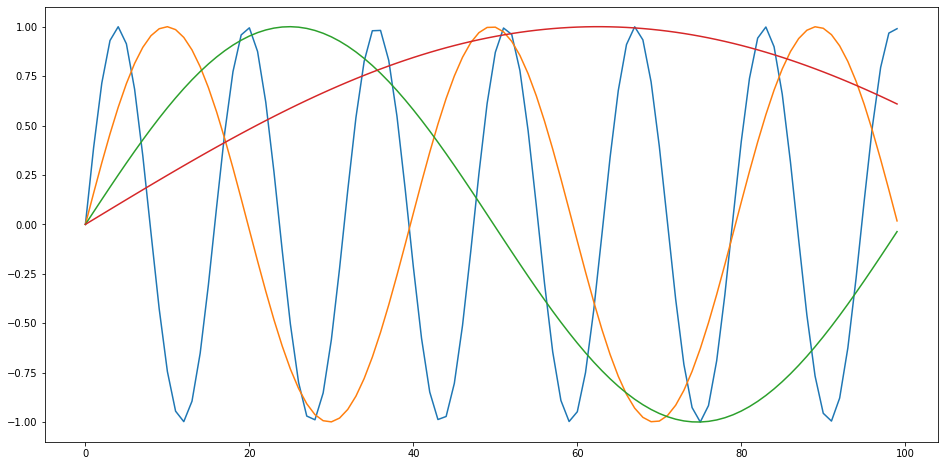

In [33]:
_, ax = plt.subplots(1, 1, figsize=(16, 8))
for i in range(1, 5): ax.plot(res[:, i])

ลองพล็อตทั้ง 20 ความถี่

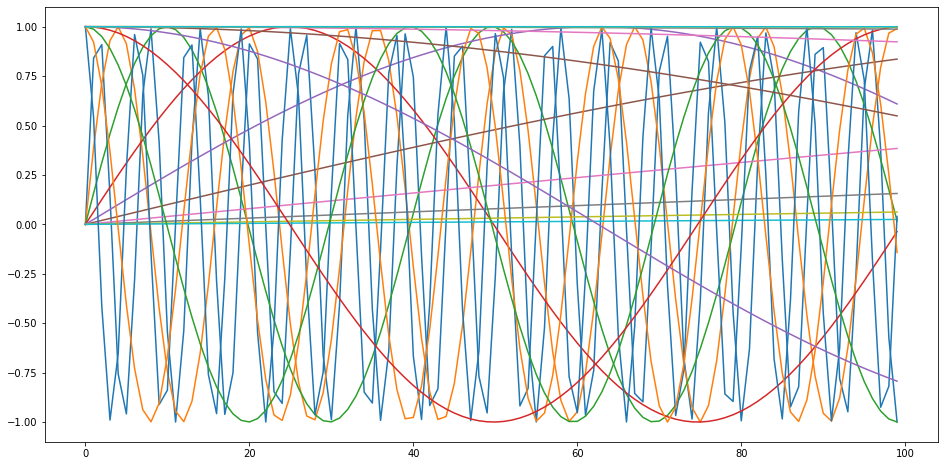

In [34]:
_, ax = plt.subplots(1, 1, figsize=(16, 8))
for i in range(0, 20): ax.plot(res[:, i])

สร้าง Module รวม Embedding คำศัพท์ เข้ากับ Positional Embedding สำหรับเตรียมไปใช้ใน โมเดล

In [0]:
class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp):
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

### Feed Forward

Feed Forward ของ Transformer ก็คือ Fully-Connected Layer ธรรมดา ๆ นี่เอง ประกอบด้วย

* Linear Layer จำนวน 2 Layer 
* Layer Norm ทำหน้าที่เหมือน BatchNorm 
* Skip Connection เพื่อให้ Gradient Flow ได้ดีเหมือน ResNet


In [0]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))
    

### Multi-Head Attention

จาก ep ที่แล้วที่เรานำเทคนิค [Attention](https://www.bualabs.com/archives/3168/what-is-attention-create-neural-machine-translation-translate-french-to-english-with-sequence-to-sequence-rnn-gru-attention-nlp-ep-11/) มาประยุกต์ใช้ เพื่อเพิ่มประสิทธิภาพให้กับโมเดล สามารถเรียนรู้ และเลือกที่จะสนใจ Input เป็นบางส่วนได้ 

Multi-Head Attention คือ ออกแบบให้โมเดลสามารถมีหลาย ๆ Attention ได้พร้อม ๆ กัน เอาหลาย ๆ Attention มาต่อขนานกันไป

In [0]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads, self.d_head, self.scale = n_heads, d_head, scale
        self.q_wgt, self.k_wgt, self.v_wgt = [nn.Linear(d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att, self.drop_res = nn.Dropout(p), nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)    

    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))                         
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head).permute(0, 2, 1, 3)

    def _apply_attention(self, q, kv, mask=None):
        bs, seq_len = q.size(0), q.size(1)
        wq, wk, wv = map(lambda o: self.create_attn_mat(*o, bs), 
                         zip((q, kv, kv), (self.q_wgt, self.k_wgt, self.v_wgt)))
        attn_score = wq @ wk.transpose(2, 3)
        if self.scale: attn_score /= math.sqrt(self.d_head)
        if mask is not None:
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

### Masking

Attention Layer ใช้ Mask ในการป้องกันไม่ให้โมเดลสนใจ Input ในบาง Step เช่น ใน Step ที่ Input เป็น Padding เป็นต้น และเราจะใช้ Mask ในการป้องกันไม่ให้โมเดลเห็นข้อมูลที่ยังไม่ควรเห็น ไม่งั้นก็จะเห็นคำตอบก่อนได้ เหมือนเป็นการโกง

In [0]:
def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1), inp.size(1)), diagonal=1)[None, None].bool()

torch.triu จะ return สามเหลี่ยมบนของ Matrix

In [67]:
torch.triu(torch.ones(10, 10), diagonal=1).bool()

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False]])

### Encoder แลก Decoder Block

นำ Multi-Head Attention และ Feed Forward มาประกอบรวมกันเป้น Encoder และ Decoder

เราไม่สามารถใช้ nn.Sequential ได้ เนื่องจาก Module นี้มี Input มากกว่า 1

In [0]:
class EncoderBlock(nn.Module):
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)

    def forward(self, x, mask=None):
        return self.ff(self.mha(x, x, mask=mask))

In [0]:
class DecoderBlock(nn.Module):
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)

    def forward(self, x, enc, mask_out=None):
        return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))


### Transformer Model

In [0]:
class Transformer(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, 
                 d_head=32, d_inner=1024, p=0.1, bias=True, scale=True, 
                 double_drop=True, pad_idx=1):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx

    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        enc, out = self.enc_emb(inp), self.dec_emb(out)
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)


# 5. Train

สร้างโมเดลจาก class ด้านบน แล้วเริ่มเทรน

In [0]:
n_x_vocab, n_y_vocab = len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos)

In [0]:
model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
learn = Learner(data, model, loss_func=CrossEntropyFlat(), 
                metrics=[accuracy, CorpusBLEU(n_y_vocab)], 
                callback_fns=[ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 5.75E-03


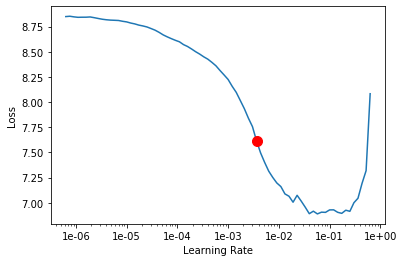

In [83]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-3

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.622857,2.809648,0.569721,0.439489,01:07
1,2.111128,2.219375,0.650945,0.478344,01:07
2,1.677478,1.837051,0.693209,0.516712,01:06
3,1.431378,1.613016,0.717861,0.542230,01:07
4,1.199037,1.497434,0.733176,0.559562,01:07
5,1.003185,1.415419,0.746720,0.575962,01:07
6,0.904077,1.364610,0.758318,0.591180,01:06
7,0.673432,1.346680,0.765849,0.603516,01:07
8,0.524068,1.363028,0.768521,0.608230,01:07
9,0.466510,1.367808,0.769538,0.609742,01:06


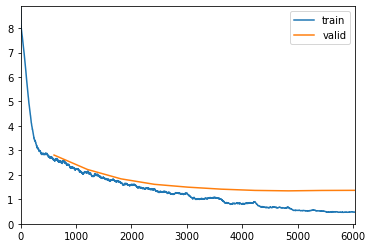

In [85]:
learn.fit_one_cycle(10, max_lr=lr, div_factor=10)

# 6. View Results

In [90]:
inputs, targets, outputs = get_predictions(learn)

In [91]:
idx = 999
inputs[idx], targets[idx], outputs[idx]

(Text xxbos quelles sont les données ventilées par sexe pertinentes , qui ne sont pas utilisées habituellement , mais sont disponibles et accessibles ?,
 Text xxbos what relevant gender - xxunk data is not currently used but available and accessible ?,
 Text what gender gender - xxunk data are not used used but are but accessible ?)

In [92]:
idx = 2222
inputs[idx], targets[idx], outputs[idx]

(Text xxbos avez - vous xxunk des xxunk ou de xxunk en afghanistan parce que vous êtes une femme ?,
 Text xxbos what about yourself xxunk : have you experienced resistance or xxunk in afghanistan because you ’re a woman ?,
 Text what would the and or or you been as in are in afghanistan , you are a woman ?)

In [93]:
idx = 3333
inputs[idx], targets[idx], outputs[idx]

(Text xxbos quels genres d’innovations organisationnelles apporte - t - on à l’intérieur de ce système ?,
 Text xxbos what kinds of organizational innovation takes place in this system ?,
 Text what types of innovation innovation is place within this system ?)

In [94]:
idx = 4444
inputs[idx], targets[idx], outputs[idx]

(Text xxbos dans quels cas la discussion informelle a - t - elle lieu ?,
 Text xxbos when does informal discussion occur ?,
 Text where did informal discussion take ?)

# 7. สรุป

* เราได้เรียนรู้ Transformer สถาปัตยกรรมใหม่ ที่ได้รับความนิยมขึ้นเรื่อย ๆ ในปัจจุบัน 
* Transformer แก้ปัญหาหลายอย่างของ ที่พบใน RNN เช่น ไม่สามารถใช้ GPU ได้อย่างเต็มความสามารถ, ทำนายผิดคำหนึ่งทำให้ผิดเป็นโดมิโน
* Transformer ก็มีปัญหาของตัวเองเหมือนกัน แต่เราได้ใช้เทคนิดหลาย ๆ เข้ามาช่วย เช่น Multi-Head Attention, Positional Encoding, Masking, LayerNorm
* ทำให้ประสิทธิภาพของโมเดลดีขึ้นกว่า ep ที่แล้วมาก เราสามารถนำไปพัฒนาต่อ และประยุกต์ใช้โมเดลนี้ ได้อีกหลายอย่าง

ตารางสรุป ผลลัพธ์การเทรนโมเดลแบบต่าง ๆ

model            | train_loss | valid_loss | seq2seq_acc | bleu
-------------------|----------|----------|----------|----------
seq2seq            | 2.823382 | 3.826643 | 0.427117 | 0.322879
\+ teacher forcing | 2.678760 |	3.732396 | 0.439311 | 0.332833
\+ attention       | 1.746102 | 3.362577 | 0.496123 | 0.416826
transformer        | 0.466510 | 1.367808 | 0.769538 | 0.609742


# Credit

* https://www.youtube.com/watch?v=AFkGPmU16QA&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=17
* https://www.bualabs.com/archives/3168/what-is-attention-create-neural-machine-translation-translate-french-to-english-with-sequence-to-sequence-rnn-gru-attention-nlp-ep-11/
* https://www.bualabs.com/archives/3134/what-is-sequence-to-sequence-neural-translate-machine-translation-french-to-english-sequence-to-sequence-model-rnn-gru-teacher-forcing-nlp-ep-10/
* https://www.bualabs.com/archives/3103/what-is-recurrent-neural-network-rnn-pytorch-gru-nlp-ep-9/
* https://www.bualabs.com/archives/3087/sentiment-classification-deep-learning-imdb-movie-reviews-positive-negative-deep-neural-network-awd-lstm-ulmfit-nlp-ep-8/
* https://www.bualabs.com/archives/3060/what-is-n-gram-sentiment-classification-imdb-movie-review-naive-bayes-logistic-regression-nlp-ep-6/
* https://arxiv.org/abs/1706.03762
* http://nlp.seas.harvard.edu/2018/04/03/attention.html
* https://huyenchip.com/2019/05/12/top-8-trends-from-iclr-2019.html
* https://arxiv.org/abs/1901.10430
* http://jalammar.github.io/illustrated-transformer/
* https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html